## Problem Background

You received a dataset from your client containing a list of names and their potential classifications.

The classifications are generated by an upstream system, but it is not always correct. 

Your task is to correctly classify the names and critically evaluate your solution.

#### Task 1: Correctly classify the names

Determine whether the name belongs to a `Person`, `Company`, or `University`:

  - You can use any library you want.
  - You can use a rule-based classification, a pre-built model/embedding, build a model yourself or a hybrid. 
  - You can keep everything in the Jupyter Notebook, write everything in a python script, or a combination of the above.
    
#### Task 2: Crtically evaluate your solution

Write a summary on the following:

  - Your exploratory data analysis.
  - What is the potential issue with your system, and how would you resolve it?
  - How would you deploy this solution in real life (you can assume anything you want to simplify the analysis, but state these assumptions).


# Notebook Information
> * **Candidate Name**: Ruan Pretorius
> * **Date**: 28 May 2021

> **Libraries Used**:
> * Python 3.7.6
> * tensorflow                         2.4.1
> * numpy                              1.19.5
> * pandas                             1.0.1
> * matplotlib                         3.1.3
> * seaborn                            0.10.0
> * scikit-learn                       0.22.1

> **Problem Approach Overview:**
>
> This problem was approached by first tokenising the words contained in the `dirty_names` column, mapping each word to an integer. Before this integer mapping, the words were all made lowercase and all special characters like `!"#$%&()*+,-./:;<=>?@[\\]^_{|}~\t\n` were filtered out. These integers represented the vocabulary of the model. 
> 
> Using the tokeniser, each name was then converted into a sequence of integers. This sequence was passed through an embedding layer so that words were represented as vectors in an abstract $D$-dimensional space. The embedding layer then passed on its sequence of word-vectors to a LSMT layer. Finally, the LSTM layer was connected to a Dense layer with three neurons and a softmax activation function to output a probability distribution representing each of the tree possible classes.
> 
> In order to achieve higher accuracy, the training data set was augmented by up-sapling minority classes (`University` and `Company`) so that the training data set was balanced.


# Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.utils import resample

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set Random Seed
This is done for repeatability so that results can be reproduced

In [2]:
RANDOM_SEED = 77
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Import Data

In [3]:
# load data set and do quick inspection with sample()
df = pd.read_csv('names_data_candidate.csv')
df.sample(10)

,dirty_name,dirty_label
2564,DR. mr. thandi alexander,Person
1209,Coastal Pl,Company
1109,Elbertina Creaven,Person
1344,MS MAXIMILIEN DOSSETTOR,Person
2751,Belinda Joubert,Person
3305,douglas potgieter,Person
3898,mr. dave maphumulo,Person
87,tshepo moodley,Person
2893,MIGUEL BORTOLAZZI,Person
4342,Dennis Collins,Company


# Initial Data Exploration
This phase is done to get a better idea of the data to be used.

In [4]:
# check number of unique names and labels
print(f"number of unique names: {df['dirty_name'].unique().shape[0]}")
print(f"unique labels: {df['dirty_label'].unique()}")

number of unique names: 4519
unique labels: ['Person' 'Company' 'University']


In [5]:
# set number of unique categories as constant (to be used later)
K = len(df['dirty_label'].unique())
K

3

In [6]:
# check how many samples in each category
print('*** number of samples per category ***')
for label in df['dirty_label'].unique():
    label_count = df[df['dirty_label']==label].shape[0]
    label_pct = np.round(((label_count / df.shape[0]) * 100),2)
    print(f"{label}: {label_count} ({label_pct}%)")

*** number of samples per category ***
Person: 3690 (81.64%)
Company: 732 (16.19%)
University: 98 (2.17%)


This data set is very unbalanced. There are very little universities and many persons. Because of this, a classifier that always predicts 'Person' will have an accuracy of over 81%. A classifier that is capable of distinguishing between 'Person' and 'Company', but ignores the 'University' class, can have an accuray of over 97%. This can be misleading since it will appear very accurate, but cannot correctly classify 'University'. Something will have to be done about this imbalance later.

In [7]:
# create integer category labels so that they can be expressed numerically
label_dict = {'Person':0, 'Company':1, 'University':2}
df['dirty_label'] = df['dirty_label'].map(label_dict)
df.head(5)

,dirty_name,dirty_label
0,Wright Pentlow,0
1,MS Sydney Hadebe,0
2,PROF. HENNIE VORSTER,0
3,ENRICA HAYTER,0
4,Teboho Ngema,0


## Train/test split
Here, the data set will be split into a training set (80%) and a testing set (20%). This is done so that the classifier can be trained on a significant amount of data to be accurate while keeping some aside for testing. The testing set is kept aside so that the classifier can be tested on data that it has never seen before in order to verify generalisability.

In [8]:
X = df['dirty_name']
y = df['dirty_label']

In [9]:
# the data will be shuffled and stritified so that there is no unbalanced concentration of any class in the training or test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True, stratify=y)

In [10]:
# double check if all classes are contained in train and test sets and are balanced (by fraction expressed as percentage)
print('** training set **')
print(y_train.value_counts() * 100.0 / X_train.shape[0])
print('\n** test set **')
print(y_test.value_counts() * 100.0 / X_test.shape[0])

** training set **
0    81.637168
1    16.205752
2     2.157080
Name: dirty_label, dtype: float64

** test set **
0    81.637168
1    16.150442
2     2.212389
Name: dirty_label, dtype: float64


## Balance data training set by up-sampling
Down-sampling is also an option, but this might cause some words to not be included in the model vocabulary. It's better to have repeats, so upsampling was chosen.
Here, only the training set is augmented. This is done because if the whole data set was augmented before the train-test split, some duplicate samples of the training set might have appeared in the test set making it not a true out-of-sample test.

In [11]:
# concat X and y values of training set
train_df = pd.concat([X_train, y_train], axis=1)
train_df.head(5)

,dirty_name,dirty_label
1284,celestyn duckerin,0
3695,Cris Voce,0
394,MS Margaux Abbot,0
1395,metalbox za divpac ct br,1
288,kyle odendaal,0


In [12]:
# split taining set into sub-sets for each class
persons_df = train_df[train_df['dirty_label']==0]
companies_df = train_df[train_df['dirty_label']==1]
universities_df = train_df[train_df['dirty_label']==2]

In [13]:
# select number to sample from each sub-set for equal representation
# for up-sampling monority catogories, choose largest category (persons)
sample_nb = persons_df.shape[0]
sample_nb

2952

In [14]:
# now sample with replacement to augment minority categories in the training set
companies_df_augmented = resample(companies_df, replace=True, n_samples=sample_nb, random_state=RANDOM_SEED)
universities_df_augmented = resample(universities_df, replace=True, n_samples=sample_nb, random_state=RANDOM_SEED)

In [15]:
# concatenate up-sampled sub-sets to make new augmented data set
train_df_augmented = pd.concat([persons_df, companies_df_augmented, universities_df_augmented])
 
# check how many instances in each category now
# now it's well-balanced
print('*** number of observations per category ***')
for label in train_df_augmented['dirty_label'].unique():
    label_count = train_df_augmented[train_df_augmented['dirty_label']==label].shape[0]
    label_pct = np.round(((label_count / train_df_augmented.shape[0]) * 100),2)
    print(f"{label}: {label_count} ({label_pct}%)")

*** number of observations per category ***
0: 2952 (33.33%)
1: 2952 (33.33%)
2: 2952 (33.33%)


In [16]:
# now split the X and y values of the training set again before proceeding
X_train = train_df_augmented['dirty_name']
y_train = train_df_augmented['dirty_label']

# Tokenise Words

In [17]:
# tokenize words in dirty_names
# also make all words lower-case and filter out some characters
# split words by spaces between them
MAX_VOCAB_SIZE = 5000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,
                      split=' ')

# fit only on training set
tokenizer.fit_on_texts(X_train) 

# apply to training and testing set (converting words to integers)
token_sequences_train = tokenizer.texts_to_sequences(X_train)
token_sequences_test = tokenizer.texts_to_sequences(X_test)

In [18]:
# double check that words were converted to integers
token_sequences_train

[[1951, 1952],
 [1953, 1954],
 [22, 1955, 1956],
 [1957, 534],
 [363, 390],
 [10, 1355, 1958],
 [963, 688],
 [964, 1356],
 [1625, 1357],
 [1959, 1960],
 [1961, 1962],
 [965, 689],
 [474, 1626],
 [363, 430],
 [1963, 1964],
 [966, 1965],
 [22, 11, 967, 1627],
 [1966, 608, 1628],
 [1134, 968],
 [609, 1358],
 [11, 391, 797],
 [1629, 1967],
 [9, 1968, 1969],
 [1970, 1971],
 [1972, 1973],
 [1135, 1974],
 [7, 11, 967, 475],
 [10, 610, 431],
 [1975, 1976],
 [1977, 1978],
 [798, 1359],
 [341, 611],
 [1136, 1630],
 [1360, 1361],
 [1362, 1979],
 [1980, 1981],
 [1982, 1363],
 [10, 799, 1983],
 [1137, 800],
 [7, 1984, 1985],
 [1986, 1987],
 [11, 16, 690, 1138],
 [1631, 26, 223, 801],
 [802, 58],
 [1632, 1988],
 [1989, 1990],
 [22, 1139, 1140],
 [1364, 1991],
 [1633, 1992],
 [1634, 1993],
 [1141, 612],
 [1994, 1995],
 [1365, 1366],
 [1367, 364],
 [16, 1996, 1997],
 [1368, 1142],
 [7, 1369, 1143],
 [289, 1144],
 [432, 803],
 [1998, 1999],
 [613, 1370],
 [342, 804],
 [1635, 2000],
 [1371, 1636],
 [10,

In [19]:
# check if MAX_VOCAB_SIZE was exceeded before proceeding
# here, it was not exceeded so all unique words were captured
max(max(i) for i in token_sequences_train) >= MAX_VOCAB_SIZE

False

In [20]:
# check word-token mappings
# here it is also clear that words have been made lowercase and special characters were removed
tokenizer.word_index

{'university': 1,
 'of': 2,
 'ltd': 3,
 'universidad': 4,
 'college': 5,
 'pty': 6,
 'dr': 7,
 'de': 8,
 'miss': 9,
 'mr': 10,
 'mrs': 11,
 'co': 12,
 'technological': 13,
 'cc': 14,
 'state': 15,
 'prof': 16,
 'pl': 17,
 'and': 18,
 'technology': 19,
 'american': 20,
 'in': 21,
 'ms': 22,
 'limited': 23,
 'health': 24,
 'normal': 25,
 'van': 26,
 'gmbh': 27,
 'p': 28,
 'international': 29,
 'the': 30,
 'rev': 31,
 'tirana': 32,
 'national': 33,
 'new': 34,
 'l': 35,
 'c': 36,
 'institute': 37,
 'hon': 38,
 'universidade': 39,
 'instituto': 40,
 'san': 41,
 'chongqing': 42,
 'metropolitana': 43,
 'sciences': 44,
 'sr': 45,
 'technical': 46,
 'université': 47,
 'tecnológica': 48,
 'central': 49,
 'corp': 50,
 'st': 51,
 "joseph's": 52,
 'illinois': 53,
 'at': 54,
 'inc': 55,
 'trust': 56,
 'company': 57,
 'africa': 58,
 'group': 59,
 'und': 60,
 'brunel': 61,
 'uxbridge': 62,
 'frostburg': 63,
 'louis': 64,
 'plc': 65,
 'ict': 66,
 'católica': 67,
 'anselmo': 68,
 'llorente': 69,
 'jv':

In [21]:
# calculate vocabulary size and assign to constant for later use
V = len(tokenizer.word_index)
V

4239

# Pad Token Sequences
Since all the names do not have the same amount of words/tokens contained in them, shorter seqences will be padded with the token `0`. This is done so that all sequences have the same length (required for passing to the LSTM layer). Another thing to note about the padding, is that these `0` tokens were placed before other tokens (pre-padding) so that when these sequences are passed to the LSTM, the important words were seen recently and not "forgotten".

In [22]:
# pre-pad token sequences in training set
data_train = pad_sequences(token_sequences_train, padding='pre')

# set T: the sequence length that will be used from this point on
T = data_train.shape[1]

# pre-pad token sequences in test set and truncate them if they exceed T
data_test = pad_sequences(token_sequences_test, maxlen=T, padding='pre')

In [23]:
# check that padding was done correctly
data_train

array([[   0,    0,    0, ...,    0, 1951, 1952],
       [   0,    0,    0, ...,    0, 1953, 1954],
       [   0,    0,    0, ...,   22, 1955, 1956],
       ...,
       [   0,    0,    0, ...,   74,   19,    1],
       [   0,    0,    0, ...,   39,    8,  170],
       [   0,    0,    0, ...,   54,  199,  200]])

In [24]:
# check sequence length (this will match the longest name)
T

11

# Create Classifier Model
This classifier model consists of the following layers: 
* `Embedding` layer to produce vector representations of tokens/words. Vectors will have $D$ dimensions.
* `LSTM` layer that accepts vector sequences from `Embedding` layer. `LSTM` layer will have $M$ hidden units.
* `Dense` layer that is fully connected to the `LSTM` units with a softmax activation function to output a probability distribution.

In [25]:
# set embedding dimensionality
D = 20

# set hidden state dimensionality
M = 15

# layers
i = Input(shape=(T,))
x = Embedding(V+1, D) (i) # add one to V becasue 0 is used for padding
x = LSTM(M) (x)
x = Dense(K, activation='softmax') (x)

model = Model(i, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 11, 20)            84800     
_________________________________________________________________
lstm (LSTM)                  (None, 15)                2160      
_________________________________________________________________
dense (Dense)                (None, 3)                 48        
Total params: 87,008
Trainable params: 87,008
Non-trainable params: 0
_________________________________________________________________


In [26]:
# compile model
# used Adam optimiser with sparse categorical corssentropy loss function since
# there are multiple classes
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train Model
The model will be trained on the augmented training data set with a batch size of 10 for 11 epochs. The number of epochs was chosen so that the model does not over-fit (see accuracy and loss plots in next section). The `%%time` command was also used to time the training.

In [27]:
%%time
# train model
r = model.fit(data_train, y_train, validation_data=(data_test, y_test), epochs=11, batch_size=10)

Epoch 1/11
886/886 [==============================] - 8s 6ms/step - loss: 1.0837 - accuracy: 0.5773 - val_loss: 0.8898 - val_accuracy: 0.8462
Epoch 2/11
886/886 [==============================] - 5s 5ms/step - loss: 0.7258 - accuracy: 0.7175 - val_loss: 0.5257 - val_accuracy: 0.8794
Epoch 3/11
886/886 [==============================] - 5s 5ms/step - loss: 0.3761 - accuracy: 0.8836 - val_loss: 0.3915 - val_accuracy: 0.9170
Epoch 4/11
886/886 [==============================] - 5s 5ms/step - loss: 0.2747 - accuracy: 0.9107 - val_loss: 0.3168 - val_accuracy: 0.9270
Epoch 5/11
886/886 [==============================] - 5s 5ms/step - loss: 0.2079 - accuracy: 0.9413 - val_loss: 0.3000 - val_accuracy: 0.9403
Epoch 6/11
886/886 [==============================] - 5s 5ms/step - loss: 0.1620 - accuracy: 0.9625 - val_loss: 0.2679 - val_accuracy: 0.9403
Epoch 7/11
886/886 [==============================] - 5s 5ms/step - loss: 0.1311 - accuracy: 0.9748 - val_loss: 0.2591 - val_accuracy: 0.9414
Epoch 

## Visualise Training and Validation Losses and Accuracy
Here are the graphs representing the accuracy and loss for both the training and test set. Notice that both the validation accuracy and validation loss converged. This is why 11 epochs were chosen. For more than 11 epochs of training, validation accuracy started dropping while validation loss started increasing (suggesting overfitting).

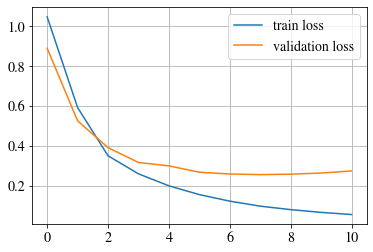

In [28]:
# plot loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.legend()
plt.grid(True);

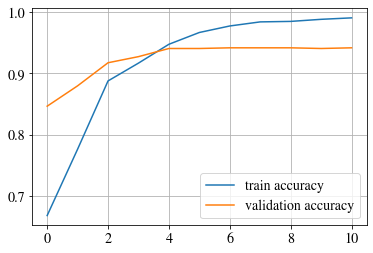

In [29]:
# plot accuracy
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.grid(True);

## Confusion Matrices and AUC Score
These can be used to more accurately visualise which classes were correctly and incorrectly classified by the model.
Here, a side-by-side comparison is shown for the test set (left) and the trainign set (right).

It seems like the classifier had the most difficulty classifying companies. As seen in the left confusion matrix for the test set, only 72% of companies were correctly classified and 28% of companies were miss-classified as persons.

Since the training data set is still unbalanced, the accuracy score can be misleading. The AUC score is also given for a more realistic value. As expected, it is slightly lower (91.57%) then the validation accuracy score of 94.14% in the last epoch.

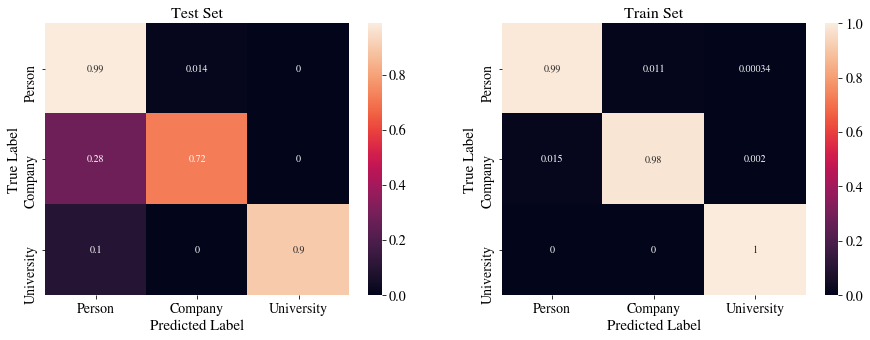

In [30]:
# confusion matrices
cm_test = confusion_matrix(y_test.values, np.argmax(model.predict(data_test), axis=1), normalize='true')
cm_train = confusion_matrix(y_train.values, np.argmax(model.predict(data_train), axis=1), normalize='true')
cm_test_df = pd.DataFrame(cm_test, index=label_dict.keys(), columns=label_dict.keys())
cm_train_df = pd.DataFrame(cm_train, index=label_dict.keys(), columns=label_dict.keys())

# plot
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(cm_test_df, annot=True, ax=axs[0])
sns.heatmap(cm_train_df, annot=True, ax=axs[1])
axs[0].set_xlabel('Predicted Label')
axs[0].set_ylabel('True Label')
axs[0].set_title('Test Set')
axs[1].set_xlabel('Predicted Label')
axs[1].set_ylabel('True Label')
axs[1].set_title('Train Set');

In [31]:
# AUC score
weighted_roc_auc_ovo = roc_auc_score(y_test, model.predict(data_test), multi_class="ovo", average="weighted")
print(f'AUC: {np.round(weighted_roc_auc_ovo*100.0,3)}%')

AUC: 91.572%


# Summary

## Exploratiry Data Analysis
This included looking at the given data set and realising it was unbalanced. 

For manual feature engineering, I would have looked at whether the names included common words that go with persons (`mr`,`dr`,`ms`), companies (`llc`,`pty`,`cc`), or universities (`college`,`university`,`campus`). Then I would have constructed binary categorica features that indicate whether these were present in the name. However, it is easy to miss some of these common words and this approach is limited to what I consider common. Instead, I opted for an embedding approach that places words in a $D$-dimensional abstract space with contextual proximity. This method uses all the words present in the training set and automatically groups similar words together.

## Limitations
As seen in the confusion matrix for the test set, this model was able to classify universities and persons reasonably well. However, only 72% of companies were correctly classified and were miss-classified as persons 28% of the time. Some improvement can be done specifically on the model's ability to classify companies. This can be done by collecting more data on company names and adding it to the data set before training.

## Deployment
To deploy this model, a container environment like Docker can be set up with all the necessary libraries installed. The trained model can also be saved in this environment. Whenever someone wants to use the model, they can simply reproduce an instance of the specified container and supply the model with some names and they'll be classified as either `Person`, `Company`, or `University`.